## Data reading and Data Insights

**Listening to Music Participant: jundlg0c, 16 days participation**

*Dataset:* 'Listening to music' vs 'Listening to music' study




#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az

In [3]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__listening_to_music_-_jundlg0c_2025-04-24 17_52_25.699//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__listening_to_music_-_jundlg0c_2025-04-24 17_52_25.699//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: jundlg0c
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [4]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: '0d21038b-cf53-4958-8879-32926d1d242b'


#### Participation of the study

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  0d21038b-cf53-4958-8879-32926d1d242b                  16


As anticipated, the study comprised a single participant, with a total participation period of 16 days.

#### Missing Values

In [6]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),            
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 0d21038b-cf53-4958-8879-32926d1d242b ---

  Outcome:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  Mediators:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0


#### Remove Participants Who Joined Outside the Study

In [7]:
# df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
# df_mea.shape[0]

#### Data Preperation

In [8]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-04-23 19:01:05.806113+00:00,Outcome,0d21038b-cf53-4958-8879-32926d1d242b,15,Listening to music!,1.0,1.0,10.0,1.0,NaN,NaN


In [9]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [10]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [11]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
31,2025-04-08 19:03:57.420070+00:00,Outcome,0d21038b-cf53-4958-8879-32926d1d242b,0,Listening to music!,2.0,1.0,10.0,1.0,NaN,NaN
29,2025-04-09 19:02:37.389766+00:00,Outcome,0d21038b-cf53-4958-8879-32926d1d242b,1,Listening to music!,1.0,2.0,10.0,1.0,NaN,NaN
27,2025-04-10 19:07:14.051946+00:00,Outcome,0d21038b-cf53-4958-8879-32926d1d242b,2,Listening to music!,1.0,1.0,10.0,1.0,NaN,NaN
24,2025-04-11 19:09:53.012022+00:00,Outcome,0d21038b-cf53-4958-8879-32926d1d242b,3,Listening to music!,4.0,4.0,10.0,1.0,NaN,NaN
23,2025-04-12 19:11:56.723095+00:00,Outcome,0d21038b-cf53-4958-8879-32926d1d242b,4,Not listening to music!,7.0,7.0,1.0,9.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)   

#### Data Shape

In [12]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 16
Columns: 11


#### Data Types of columns

In [13]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [14]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])
df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}
for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),       
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 0d21038b-cf53-4958-8879-32926d1d242b ---

  Outcome:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  Mediators:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question1_response:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question2_response:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question3_response:
    Start date:           2025-04-08
    End of expected 16d:  2025-04-23
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question4_re

#### Missing Values for Confirmations between 08.00 - 21.00

In [15]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=16, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 16 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

All 16 days have participation confirmations; no missing days found.


#### Summary Statistics

In [16]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             16.000000                   16.000000   
mean               7.500000                    4.375000   
std                4.760952                    2.986079   
min                0.000000                    1.000000   
25%                3.750000                    1.000000   
50%                7.500000                    4.000000   
75%               11.250000                    7.000000   
max               15.000000                    9.000000   

       survey1_question2_response  survey1_question3_response  \
count                   16.000000                    16.00000   
mean                     4.500000                     5.50000   
std                      3.286335                     4.64758   
min                      1.000000                     1.00000   
25%                      1.000000                     1.00000   
50%                      4.500000               

In [17]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 31 to 0
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            16 non-null     datetime64[ns, UTC]
 1   measurement_name            16 non-null     object             
 2   participant_id              16 non-null     object             
 3   current_day_of_study        16 non-null     int64              
 4   current_intervention_name   16 non-null     object             
 5   survey1_question1_response  16 non-null     float64            
 6   survey1_question2_response  16 non-null     float64            
 7   survey1_question3_response  16 non-null     float64            
 8   survey1_question4_response  16 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

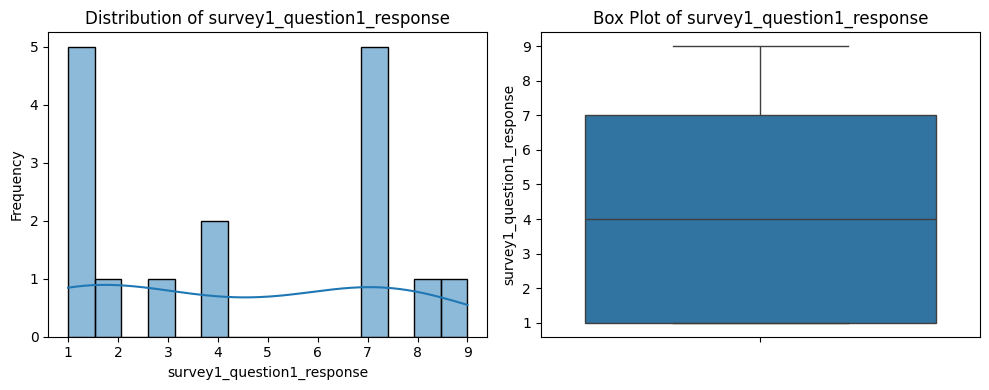

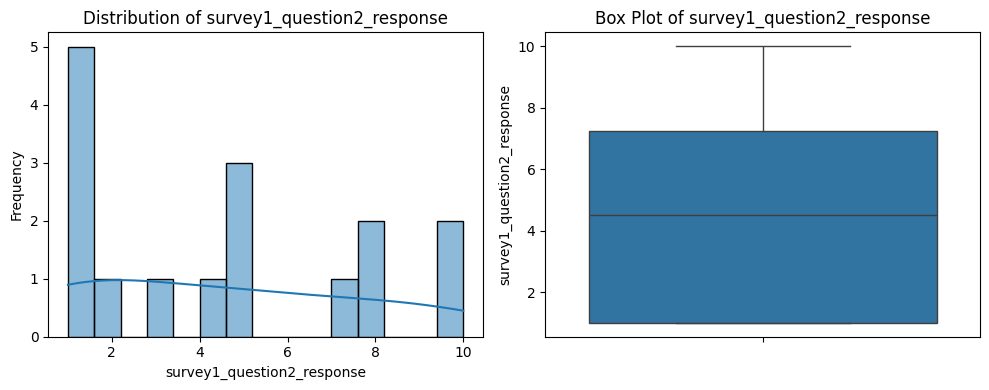

In [18]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

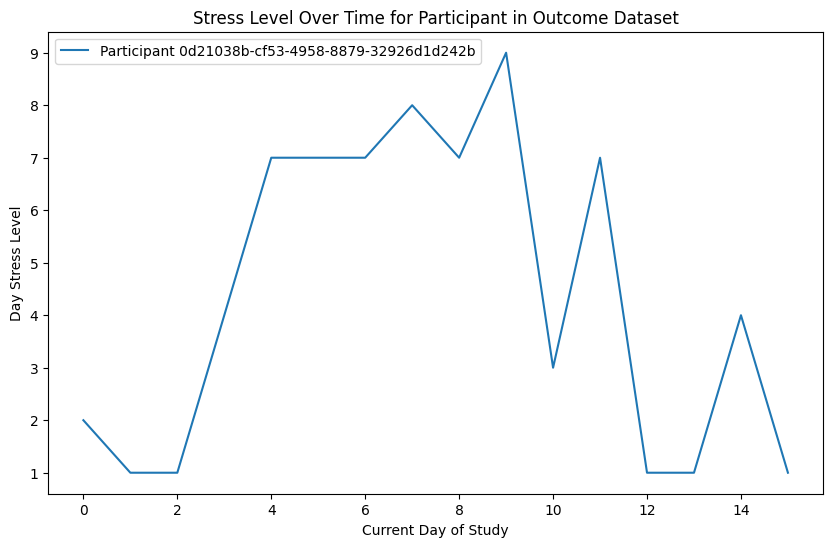

In [19]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Participant in Outcome Dataset')

plt.legend()
plt.show()


#### Scatterplot

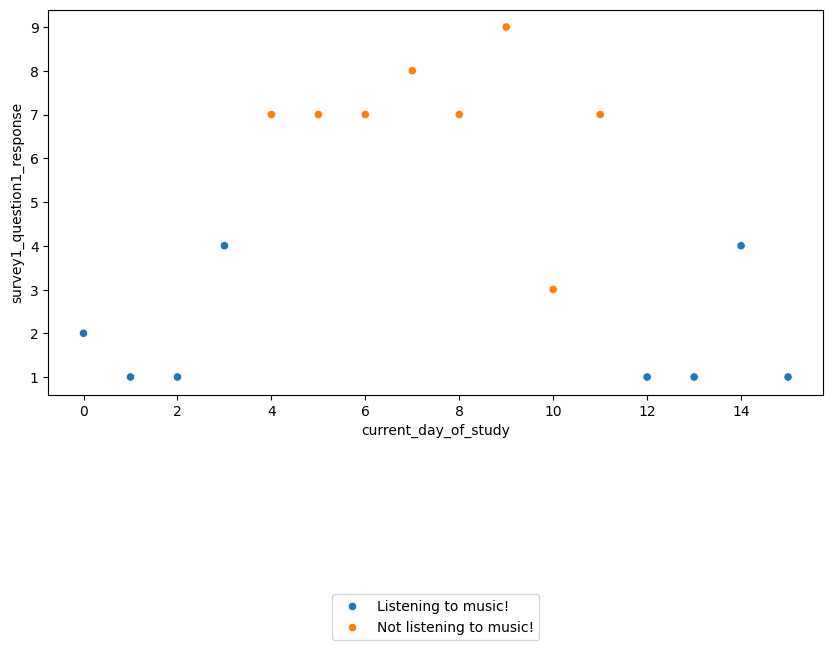

In [20]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

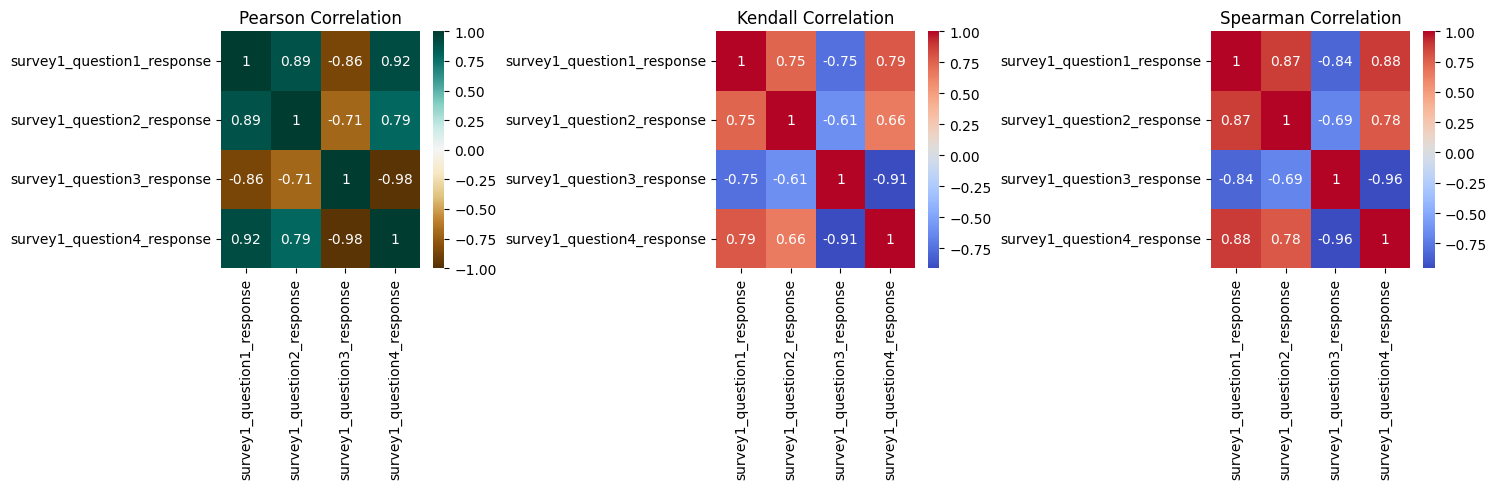

In [21]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Listening to Music vs Not Listening to Music

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

#### Examination of Outcomes: Today Stress Level

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Listening to music!",
        "Not listening to music!"
    ])
]

listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to music!",
    'survey1_question1_response'
]
avoid_listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to music!",
    'survey1_question1_response'
]

n_listening        = listening.count()
n_avoid_listening  = avoid_listening.count()
std_listening      = listening.std(ddof=1)
std_avoid_listening = avoid_listening.std(ddof=1)

print(f"Listening to music:       n = {n_listening}, std = {std_listening:.2f}, mean = {listening.mean():.2f}")
print(f"Avoid listening to music: n = {n_avoid_listening}, std = {std_avoid_listening:.2f}, mean = {avoid_listening.mean():.2f}\n")

Listening to music:       n = 8, std = 1.36, mean = 1.88
Avoid listening to music: n = 8, std = 1.73, mean = 6.88



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [23]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Listening to music!",
        "Not listening to music!"
    ])
]

listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to music!",
    'survey1_question2_response'
]
avoid_listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to music!",
    'survey1_question2_response'
]

n_listening        = listening.count()
n_avoid_listening  = avoid_listening.count()
std_listening      = listening.std(ddof=1)
std_avoid_listening = avoid_listening.std(ddof=1)

print(f"Listening to music:       n = {n_listening}, std = {std_listening:.2f}, mean = {listening.mean():.2f}")
print(f"Avoid listening to music: n = {n_avoid_listening}, std = {std_avoid_listening:.2f}, mean = {avoid_listening.mean():.2f}\n")


Listening to music:       n = 8, std = 1.58, mean = 2.25
Avoid listening to music: n = 8, std = 3.01, mean = 6.75



#### Examination of Outcomes: Mean Stress-Relief Score for Listening to music (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much listening to music alleviated participants’ stress on days they performed.

In [24]:
df_mea.survey1_question3_text[0]

'How much did this method (listening to music) help you feel better about yourself? <b>(Answer ONLY if you have listened to music!)</b>'

In [25]:
# How much did this method (listening to music) help you feel better about yourself? (Answer ONLY if you have listened to music!)
mean_q3_listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to music!",
    'survey1_question3_response'
].mean()
mean_q3_listening.item()


10.0

**Mean Self-Improvement Score for Listening to Music (Q3): 10.00:**
When he listened to music, he rated how much it helped him feel better about himself as 10 out of 10, indicating that music provided the maximum boost to his self-perception.

#### Examination of Outcomes: Mean Stress-Management Difficulty Without Listening to Music (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not listen music.

In [26]:
df_mea.survey1_question4_text[0]

'When you are not practicing the method (not listening to music) today, do you feel a lack or difficulty managing your stress? <b>(Answer ONLY if you have NOT listened to music!)</b>'

In [27]:
# 'When you are not practicing the method (not listening to music) today, do you feel a lack or difficulty managing your stress? <b>(Answer ONLY if you have NOT listened to music!)</b>'
mean_q4_no_listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to music!",
    'survey1_question4_response'
].mean()
mean_q4_no_listening.item()


9.375

**Mean Stress-Management Difficulty Score Without Listening to Music (Q4): 9.375:**
When he didn’t listen to music, he rated his stress-management difficulty at 9.375 out of 10, reporting that he felt the absence of music and found it much harder to cope with stress.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [28]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Listening to music!", "Not listening to music!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Listening to music!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.748
Model:                                    OLS   Adj. R-squared:                  0.730
Method:                         Least Squares   F-statistic:                     41.48
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):           1.55e-05
Time:                                10:06:09   Log-Likelihood:                -28.674
No. Observations:                          16   AIC:                             61.35
Df Residuals:                              14   BIC:                             62.89
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [29]:
# GLSAR Regression with AR(1) errors (Feasible GLS) 
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.847
Model:                                  GLSAR   Adj. R-squared:                  0.835
Method:                         Least Squares   F-statistic:                     71.93
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):           1.17e-06
Time:                                10:06:09   Log-Likelihood:                -26.296
No. Observations:                          15   AIC:                             56.59
Df Residuals:                              13   BIC:                             58.01
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


#### Bayesian AR(1) Model of Daily Stress Response to Music and Mediators

In [30]:
def run_model(fac_cols, beta_names):
    out = df_mea[df_mea['measurement_name'] == 'Outcome']
    med = df_mea[df_mea['measurement_name'] == 'Mediators']
    data = (
        pd.merge(
            out[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']],
            med[['current_day_of_study'] + fac_cols] if fac_cols else out[['current_day_of_study']],
            on='current_day_of_study',
            how='inner'
        ).dropna().sort_values('current_day_of_study').reset_index(drop=True)
    )
    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Listening to music!").astype(int).values
    n = len(data)
    fac_arrays = [data[col].values for col in fac_cols] if fac_cols else []

    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        betas = [pm.Normal(beta_name, mu=0, sigma=1) for beta_name in beta_names]
        rho = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = beta0 + beta_int * interv
        for beta, fac in zip(betas, fac_arrays):
            mu += beta * fac
        pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])
        for t in range(1, n):
            adjustment = rho * (y[t-1] - mu[t-1])
            pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9, return_inferencedata=True)
    summary = az.summary(trace, var_names=['beta_int'] + beta_names + ['rho', 'sigma'], hdi_prob=0.95)
    print(summary)
    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()
    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")
    prob = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(Stress reduction of listening to music ≥ 0.5) = {prob:.2%}\n")

print("Model result with neither fac1 nor fac2 (intervention only):")
run_model([], [])

print("Model result with only fac1:")
run_model(['survey2_question1_response'], ['beta_f1'])

print("Model result with only fac2:")
run_model(['survey2_question2_response'], ['beta_f2'])

print("Model result with both fac1 and fac2:")
run_model(['survey2_question1_response', 'survey2_question2_response'], ['beta_f1', 'beta_f2'])

Model result with neither fac1 nor fac2 (intervention only):


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 59 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -2.065  1.106    -4.271     -0.122      0.075    0.032     219.0   
rho       0.276  0.348    -0.340      0.958      0.023    0.014     219.0   
sigma     2.033  0.376     1.256      2.722      0.022    0.013     283.0   

          ess_tail  r_hat  
beta_int     434.0   1.01  
rho          382.0   1.01  
sigma        487.0   1.01  
P(beta_int ≤ –0.5) = 92.70%
P(–0.5 < beta_int < 0) = 4.30%
P(beta_int ≥ 0) = 3.00%
P(Stress reduction of listening to music ≥ 0.5) = 92.70%

Model result with only fac1:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 83 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -2.096  0.981    -3.891     -0.154      0.049    0.027     400.0   
beta_f1   0.259  0.265    -0.243      0.824      0.013    0.009     407.0   
rho       0.247  0.338    -0.387      0.889      0.021    0.012     262.0   
sigma     2.004  0.390     1.246      2.747      0.017    0.012     501.0   

          ess_tail  r_hat  
beta_int     366.0   1.00  
beta_f1      312.0   1.00  
rho          443.0   1.02  
sigma        602.0   1.00  
P(beta_int ≤ –0.5) = 94.30%
P(–0.5 < beta_int < 0) = 4.50%
P(beta_int ≥ 0) = 1.20%
P(Stress reduction of listening to music ≥ 0.5) = 94.30%

Model result with only fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 135 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -2.271  1.085    -4.232     -0.305      0.061    0.028     321.0   
beta_f2   0.315  0.275    -0.204      0.887      0.013    0.010     476.0   
rho       0.116  0.365    -0.549      0.837      0.024    0.009     236.0   
sigma     1.949  0.392     1.251      2.737      0.021    0.010     320.0   

          ess_tail  r_hat  
beta_int     571.0   1.01  
beta_f2      395.0   1.00  
rho          527.0   1.01  
sigma        455.0   1.01  
P(beta_int ≤ –0.5) = 94.30%
P(–0.5 < beta_int < 0) = 3.80%
P(beta_int ≥ 0) = 1.90%
P(Stress reduction of listening to music ≥ 0.5) = 94.30%

Model result with both fac1 and fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 160 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -2.196  1.065    -4.165     -0.161      0.050    0.032     454.0   
beta_f1   0.135  0.461    -0.776      1.013      0.023    0.013     405.0   
beta_f2   0.151  0.421    -0.572      1.023      0.021    0.011     392.0   
rho       0.168  0.358    -0.533      0.814      0.018    0.013     404.0   
sigma     1.988  0.387     1.267      2.706      0.016    0.011     546.0   

          ess_tail  r_hat  
beta_int     452.0   1.00  
beta_f1      624.0   1.00  
beta_f2      572.0   1.00  
rho          389.0   1.02  
sigma        497.0   1.00  
P(beta_int ≤ –0.5) = 94.30%
P(–0.5 < beta_int < 0) = 3.80%
P(beta_int ≥ 0) = 1.90%
P(Stress reduction of listening to music ≥ 0.5) = 94.30%



#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 96 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -4.619  0.854    -6.339     -2.925      0.043    0.039     408.0   
rho      -0.207  0.318    -0.814      0.420      0.018    0.013     320.0   
sigma     1.688  0.388     0.994      2.436      0.021    0.018     352.0   

          ess_tail  r_hat  
beta_int     510.0    1.0  
rho          388.0    1.0  
sigma        361.0    1.0  
P(beta_int ≤ –0.5) = 99.90%
P(–0.5 < beta_int < 0) = 0.00%
P(beta_int ≥ 0) = 0.10%


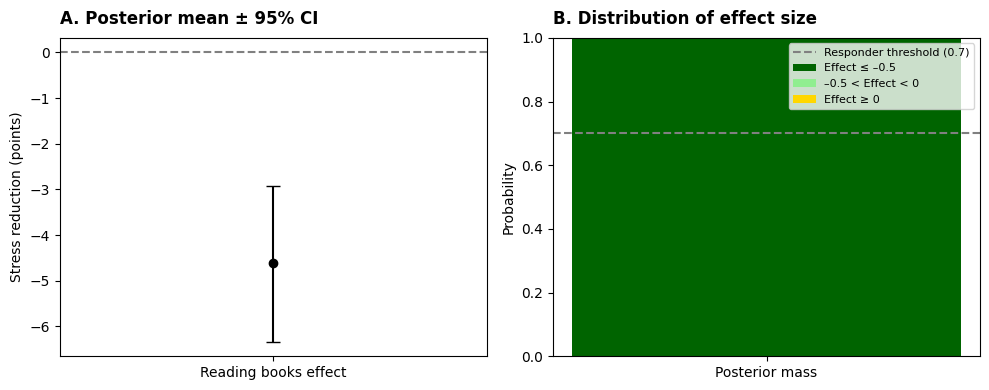

In [31]:
outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
data = (
    outcome_data[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']]
    .dropna()
    .sort_values('current_day_of_study')
    .reset_index(drop=True)
)

y      = data['survey1_question1_response'].values
interv = (data['current_intervention_name'] == "Listening to music!").astype(int).values
n      = len(data)

mad = np.median(np.abs(y - np.median(y)))
scale = max(mad, 2.0)

with pm.Model() as model:
    beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)   
    beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)   
    rho      = pm.Uniform('rho',       lower=-1, upper=1)         
    sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)       

    mu = beta0 + beta_int * interv

    pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])

    for t in range(1, n):
        adjustment = rho * (y[t-1] - mu[t-1])
        pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])

    trace = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True
    )

summary = az.summary(trace, var_names=['beta_int', 'rho', 'sigma'], hdi_prob=0.95)
print(summary)

beta_samples = trace.posterior['beta_int'].values.flatten()

p_le_neg05 = (beta_samples <= -0.5).mean()
p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
p_ge0      = (beta_samples >= 0).mean()

print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

mean_beta = summary.loc['beta_int', 'mean']
hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

ax = axes[0]
ax.errorbar(0, mean_beta,
            yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
            fmt='o', capsize=5, color='black')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks([0])
ax.set_xticklabels(['Reading books effect'])
ax.set_ylabel('Stress reduction (points)')
ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

ax = axes[1]
ax.bar(0, p_le_neg05, width=0.6, color='darkgreen',  label='Effect ≤ –0.5')
ax.bar(0, p_between,  width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < Effect < 0')
ax.bar(0, p_ge0,      width=0.6, bottom=p_le_neg05+p_between, color='gold', label='Effect ≥ 0')
ax.axhline(0.7, color='gray', linestyle='--', label='Responder threshold (0.7)')
ax.set_xticks([0])
ax.set_xticklabels(['Posterior mass'])
ax.set_ylim(0, 1)
ax.set_ylabel('Probability')
ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()